In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.decomposition import PCA

import neurogym as ngym
import matplotlib.pyplot as plt

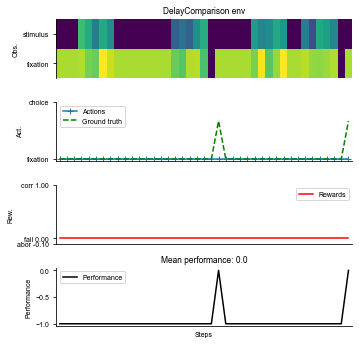

In [2]:
# Environment
task = 'DelayComparison-v0'
timing = {'delay': ('choice', [200, 400, 800, 1600, 3200]),
          'response': ('constant', 500)}
kwargs = {'dt': 100, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task,
                       env_kwargs=kwargs,
                       batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2, def_act=0)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

In [3]:
class CTRNN(nn.Module):
  def __init__(self, input_size, hidden_size, dt=None, **kwargs):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.tau = 100
    if dt is None:
      alpha = 1
    else:
      alpha = dt / self.tau
    self.alpha = alpha
    self.oneminusalpha = 1 - alpha

    self.input2h = nn.Linear(input_size, hidden_size)
    self.h2h = nn.Linear(hidden_size, hidden_size)

  def init_hidden(self, input_shape):
    batch_size = input_shape[1]
    return torch.zeros(batch_size, self.hidden_size)

  def recurrence(self, input, hidden):
    """Recurrence helper."""
    pre_activation = self.input2h(input) + self.h2h(hidden)
    h_new = torch.relu(hidden * self.oneminusalpha +
                       pre_activation * self.alpha)
    return h_new

  def forward(self, input, hidden=None):
    """Propogate input through the network."""
    if hidden is None:
      hidden = self.init_hidden(input.shape).to(input.device)

    output = []
    steps = range(input.size(0))
    for i in steps:
      hidden = self.recurrence(input[i], hidden)
      output.append(hidden)

    output = torch.stack(output, dim=0)
    return output, hidden

In [4]:
class RNNNet(nn.Module):
  """Recurrent network model.

  Args:
      input_size: int, input size
      hidden_size: int, hidden size
      output_size: int, output size
      rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
  """

  def __init__(self, input_size, hidden_size, output_size, **kwargs):
    super().__init__()

    # Continuous time RNN
    self.rnn = CTRNN(input_size, hidden_size, **kwargs)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    rnn_activity, _ = self.rnn(x)
    out = self.fc(rnn_activity)
    return out, rnn_activity

In [5]:
# Instantiate the network and print information
hidden_size = 64
net = RNNNet(input_size=input_size,
             hidden_size=hidden_size,
             output_size=output_size,
             dt=env.dt)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

RNNNet(
  (rnn): CTRNN(
    (input2h): Linear(in_features=2, out_features=64, bias=True)
    (h2h): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc): Linear(in_features=64, out_features=3, bias=True)
)


In [6]:
running_loss = 0
running_acc = 0
for i in range(2000):
  inputs, labels_np = dataset()
  labels_np = labels_np.flatten()
  inputs = torch.from_numpy(inputs).type(torch.float)
  labels = torch.from_numpy(labels_np).type(torch.long)

  # in your training loop:
  optimizer.zero_grad()  # zero the gradient buffers
  output, _ = net(inputs)
  output = output.view(-1, output_size)
  loss = criterion(output, labels)
  loss.backward()
  optimizer.step()  # Does the update

  running_loss += loss.item()
  # Compute performance
  output_np = np.argmax(output.detach().numpy(), axis=-1)
  ind = labels_np > 0  # Only analyze time points when target is not fixation
  running_acc += np.mean(labels_np[ind] == output_np[ind])
  if i % 100 == 99:
    running_loss /= 100
    running_acc /= 100
    print('Step {}, Loss {:0.4f}, Acc {:0.3f}'.format(i + 1, running_loss, running_acc))
    running_loss = 0
    running_acc = 0

Step 100, Loss 0.2871, Acc 0.000
Step 200, Loss 0.0842, Acc 0.084
Step 300, Loss 0.0403, Acc 0.559
Step 400, Loss 0.0285, Acc 0.694
Step 500, Loss 0.0239, Acc 0.754
Step 600, Loss 0.0212, Acc 0.783
Step 700, Loss 0.0184, Acc 0.807
Step 800, Loss 0.0176, Acc 0.819
Step 900, Loss 0.0152, Acc 0.852
Step 1000, Loss 0.0128, Acc 0.879
Step 1100, Loss 0.0108, Acc 0.897
Step 1200, Loss 0.0103, Acc 0.900
Step 1300, Loss 0.0103, Acc 0.895
Step 1400, Loss 0.0100, Acc 0.903
Step 1500, Loss 0.0102, Acc 0.892
Step 1600, Loss 0.0081, Acc 0.917
Step 1700, Loss 0.0096, Acc 0.899
Step 1800, Loss 0.0088, Acc 0.909
Step 1900, Loss 0.0085, Acc 0.909
Step 2000, Loss 0.0079, Acc 0.918


# Visualization

In [15]:
def run(num_trial = 1):
    env.reset(no_step=True)
    perf = 0
    activity_dict = {}
    trial_infos = {}
    for i in range(num_trial):
      env.new_trial()
      ob, gt = env.ob, env.gt
      inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
      action_pred, rnn_activity = net(inputs)
      rnn_activity = rnn_activity[:, 0, :].detach().numpy()
      activity_dict[i] = rnn_activity
      trial_infos[i] = env.trial
    
    # Concatenate activity for PCA
    activity = np.concatenate(list(activity_dict[i] for i in range(num_trial)), axis=0)
    print('Shape of the neural activity: (Time points, Neurons): ', activity.shape)

    # Print trial informations
    for i in range(5):
      if i >= num_trial: break
      print('Trial ', i, trial_infos[i])
    
    pca = PCA(n_components=2)
    pca.fit(activity)
    # print('Shape of the projected activity: (Time points, PCs): ', activity_pc.shape)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))
    for i in range(num_trial):
        activity_pc = pca.transform(activity_dict[i])
        trial = trial_infos[i]
        color = 'red' if trial['ground_truth'] == 0 else 'blue'
        _ = ax1.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)
        if i < 3:
            _ = ax2.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)
    ax1.set_xlabel('PC 1')
    ax1.set_ylabel('PC 2')

Shape of the neural activity: (Time points, Neurons):  (18, 64)
Trial  0 {'ground_truth': 1, 'vpair': (22, 14), 'v1': 22, 'v2': 14}


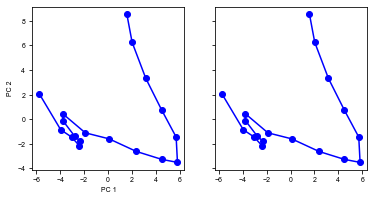

In [16]:
run(num_trial=1)

Shape of the neural activity: (Time points, Neurons):  (562, 64)
Trial  0 {'ground_truth': 1, 'vpair': (18, 10), 'v1': 18, 'v2': 10}
Trial  1 {'ground_truth': 2, 'vpair': (34, 26), 'v1': 26, 'v2': 34}
Trial  2 {'ground_truth': 1, 'vpair': (26, 18), 'v1': 26, 'v2': 18}
Trial  3 {'ground_truth': 2, 'vpair': (30, 22), 'v1': 22, 'v2': 30}
Trial  4 {'ground_truth': 1, 'vpair': (30, 22), 'v1': 30, 'v2': 22}


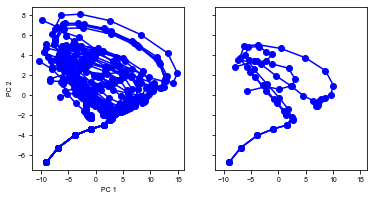

In [18]:
run(num_trial=20)

Shape of the neural activity: (Time points, Neurons):  (3114, 64)
Trial  0 {'ground_truth': 1, 'vpair': (34, 26), 'v1': 34, 'v2': 26}
Trial  1 {'ground_truth': 2, 'vpair': (22, 14), 'v1': 14, 'v2': 22}
Trial  2 {'ground_truth': 2, 'vpair': (30, 22), 'v1': 22, 'v2': 30}
Trial  3 {'ground_truth': 2, 'vpair': (30, 22), 'v1': 22, 'v2': 30}
Trial  4 {'ground_truth': 1, 'vpair': (26, 18), 'v1': 26, 'v2': 18}


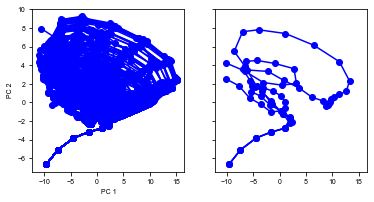

In [17]:
run(num_trial=100)